In [58]:
# Input data
import numpy as np
from utilities import *

# test and train read
X_train_valid, Y_train_valid, list_ch_train_valid = read_data(data_path="../../../datasets/har/har-data/", 
                                                              split="train")
X_test, Y_test, list_ch_test = read_data(data_path="../../../datasets/har/har-data/", split="test")

assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)

print(np.mean(Y_train_valid==0), np.mean(Y_train_valid==1), np.mean(Y_train_valid==2), 
      np.mean(Y_train_valid==3), np.mean(Y_train_valid==4), np.mean(Y_train_valid==5),
      np.mean(Y_train_valid==6), np.mean(Y_train_valid==7))

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0


In [59]:
# Preparing input and output data
# from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid).reshape(-1)==0), np.mean((Y_train_valid).reshape(-1)==1),
     np.mean((Y_train_valid).reshape(-1)==2), np.mean((Y_train_valid).reshape(-1)==3),
     np.mean((Y_train_valid).reshape(-1)==4), np.mean((Y_train_valid).reshape(-1)==5),
     np.mean((Y_train_valid).reshape(-1)==6), np.mean((Y_train_valid).reshape(-1)==7))

Y_train_valid_onehot = one_hot(labels=Y_train_valid.reshape(-1), n_class=6) 
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352, 6) float64 (2947, 6) float64


In [60]:
# Train and valid split
from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [61]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [62]:
# ## Hyperparameters
# # Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
# seq_len = X_train_norm.shape[1] # Number of steps: each trial length
# n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# # Output labels
# n_classes = Y_train_valid.max(axis=0)
# assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
# print('n_classes', n_classes)

In [63]:
# Feed the data from python/numpy to tensorflow framework
# NWC or NHWC: Number, Height/Width, Channels
# print(X_train_norm.shape, X_train_norm.dtype)
# The common mistake the N or number of batches or number of input should be minimum of train, valid, or test
# obviously should be validation set since it is the smallest one then.
# The rest of other dimensions/axes/axises are all the same
# print(X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)
# print(X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)
# The N should be the minimum of these three bacthes so that we can train, validate and test.
# W, Cin are the same for all training, validation, testing
N, W, Cin = X_valid_norm.shape[0], X_train_norm.shape[1], X_train_norm.shape[2]
# print(N, W, Cin)
# inputs_ = tf.placeholder(tf.float32, [N, W, Cin], name =None)
X = tf.placeholder(dtype=tf.float32, name=None, shape=[N, W, Cin])
print(X.shape, X.dtype)

# Channels for output or classes or dimensions for output
# print(Y_train_valid.shape, Y_train_valid.dtype)
# print(Y_train_valid.max(axis=0), Y_test.max(axis=0))
assert Y_train_valid.max(axis=0)==Y_test.max(axis=0)
# This is the class label or number from 1, ..., 6
Cout = Y_train_valid.max(axis=0)
# labels_ = tf.placeholder(tf.float32, [N, Cout], name =None)
Y = tf.placeholder(dtype=tf.float32, name=None, shape=[N, Cout])
print(Y.shape, Y.dtype)

(2206, 128, 9) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [64]:
# This is one convolution channel for example
print(X.shape, X.dtype)
# variable/weight shape should be based on NWC but the other way around WCN
# Width, Channels, Number of weights
Wwidth, Wchannels, Wnumber = X.shape[1].value//2, X.shape[2].value, X.shape[2].value*2 # double up the input channels
shape = [Wwidth, Wchannels, Wnumber]
# print(shape)
# initializing the weight using normal
initial_value = tf.random_normal(dtype=X.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
# Weight, variable and itsshape
Wconv = tf.Variable(dtype=X.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
# input shape and type as the input tensor
# convolution operation as well
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=X)
print(Xconv.shape, Xconv.dtype)

(2206, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(2206, 64, 18) <dtype: 'float32'>


In [65]:
# This is one multiplication channel for example
# Flatten and add dropout + predicted output
# WHY!!!!!!!! this is not working!!
shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
# shape = [-1, Xconv.shape[1].value*Xconv.shape[2].value]
# print(shape, 64*18) # as a double check
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
# The weight for fully connected/dense layer and for multiplication not convolution though.
# multiplication is so much easier than convolution in terms of implementation.
# shape = this shape should be the same NWC as well but the other way around or maybe transposed
# X is NWC which is describing the tensor shape0, 1, 2
# labels which are the output labels are supposed to be NC, 
# N:batch size, C: output channels or output classes or dimensions 
Wchannels, Wnumber = Xconv_reshaped.shape[1].value, Y.shape[1].value
shape = [Wchannels, Wnumber]
# print(shape)
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
logits = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(logits.shape, logits.dtype)
print(Y.shape, Y.dtype)

(2206, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(2206, 6) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [66]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )
# minimize(
#     loss,
#     global_step=None,
#     var_list=None,
#     gate_gradients=GATE_OP,
#     aggregation_method=None,
#     colocate_gradients_with_ops=False,
#     name=None,
#     grad_loss=None
# )
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=cost)
print('optimizer', optimizer)

# # Accuracy
# correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
# print('correct_pred, accuracy', correct_pred, accuracy)

# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("softmax_cross_entropy_with_logits_3/Reshape_2:0", shape=(2206,), dtype=float32) Tensor("Mean_3:0", shape=(), dtype=float32)
optimizer name: "Adam_3"
op: "NoOp"
input: "^Adam_3/update_Variable_5/ApplyAdam"
input: "^Adam_3/update_Variable_6/ApplyAdam"
input: "^Adam_3/Assign"
input: "^Adam_3/Assign_1"



In [67]:
# for X, Y in get_batches(X=X_train_norm, batch_size=N, y=Y_train_onehot):
#     print(X.shape, X.dtype, Y.shape, Y.dtype)

In [68]:
# Plotting the learning/loss curve
train_loss, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    epochs=1
    for epoch in range(epochs):
        
        # Training
        loss_batch, acc_batch = [], []
        for Xarr, Yarr in get_batches(X=X_train_norm, batch_size=N, y=Y_train_onehot):
            
            # feeding the training data and fetching the output loss and accuracy and gradients as well;
            feed_dict = {X:Xarr, Y:Yarr}
            loss, _ = sess.run(feed_dict=feed_dict, fetches=[cost, optimizer])
            loss_batch.append(loss)
        
        # Averaging the loss of the batch/minibatch
        train_loss.append(np.mean(loss_batch))
        
        # validation
        feed_dict = {X:X_valid_norm, Y:Y_valid_onehot}
        loss = sess.run(feed_dict=feed_dict, fetches=[cost])
        valid_loss.append(np.mean(loss))
        
        print('epoch:', epoch, 'training loss:', np.mean(loss_batch), 'validation loss:', np.mean(loss))
            
    saver.save(save_path='checkpoints/model.ckpt', sess=sess)

epoch: 0 training loss: 622.09863 validation loss: 552.83795


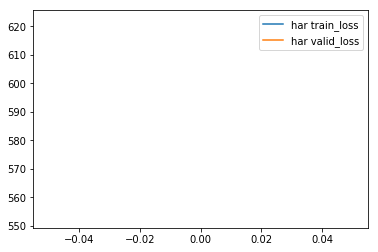

In [69]:
import matplotlib.pyplot as mplot
# % %matplotlib inline
# this is keeping the mpl inline or outline
# inline would inside this block and outline/out of block would be out of this block.
# %matplotlib inline
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [70]:
# Testing and playing around with checkpoints and trained model saved or saved trained model
# loaded_ckpt = tf.train.load_checkpoint(ckpt_dir_or_file='checkpoints/cnn-har.ckpt')
# loaded_ckpt.debug_string, 
# loaded_ckpt.get_variable_to_dtype_map()
# loaded_ckpt.get_variable_to_shape_map()

In [71]:
with tf.Session() as sess:
    # Restore the validated model
    save_path = tf.train.latest_checkpoint(checkpoint_dir='checkpoints')
    saver.restore(save_path=save_path, sess=sess)
    
    loss_batch = []
    for Xarr, Yarr in get_batches(X=X_test_norm, batch_size=N, y=Y_test_onehot):
        print(Xarr.shape, Yarr.shape)
        feed_dict = {X:Xarr, Y:Yarr}
#         loss = sess.run(feed_dict=feed_dict, fetches=[cost])
#         loss_batch.append(loss)


#     # Print info for every iter/epoch
#     print('test_loss:', np.mean(loss_batch))
# #     print("Test loss: {:6f}".format(np.mean(test_loss))

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
(2206, 128, 9) (2206, 6)
